In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from experiment_setup import get_model, set_random, build_estimator
from uncertainty_estimator.masks import build_masks, DEFAULT_MASKS, BASIC_MASKS
from dataloader.toy import ToyQubicData, ToySinData
from model.mlp import MLP
from model.dense import Dense
from model.trainer import Trainer
import torch
torch.cuda.set_device(1)

In [3]:
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
config = {
    'nn_runs': 50,
    'verbose': False,
    'use_cache': True, 
    'layers': [1, 32, 32, 16, 1],
    'patience': 500,
    'dropout_train': 0,
    'dropout_uq': 0
}

### Visualizing on toy data

#### Generate dataset


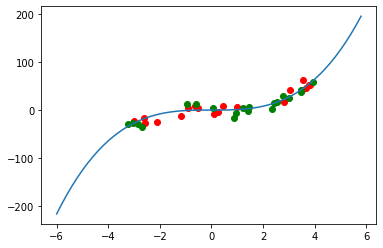

In [5]:
dataset = 'sin'

data_class = ToyQubicData

x_train, y_train = data_class(use_cache=config['use_cache']).dataset('train')
x_val, y_val = data_class(use_cache=config['use_cache']).dataset('val')
x_true, y_true = data_class().dataset('ground_truth')
    
plt.plot(x_true, y_true)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_val, y_val, color='green')


#### Train model


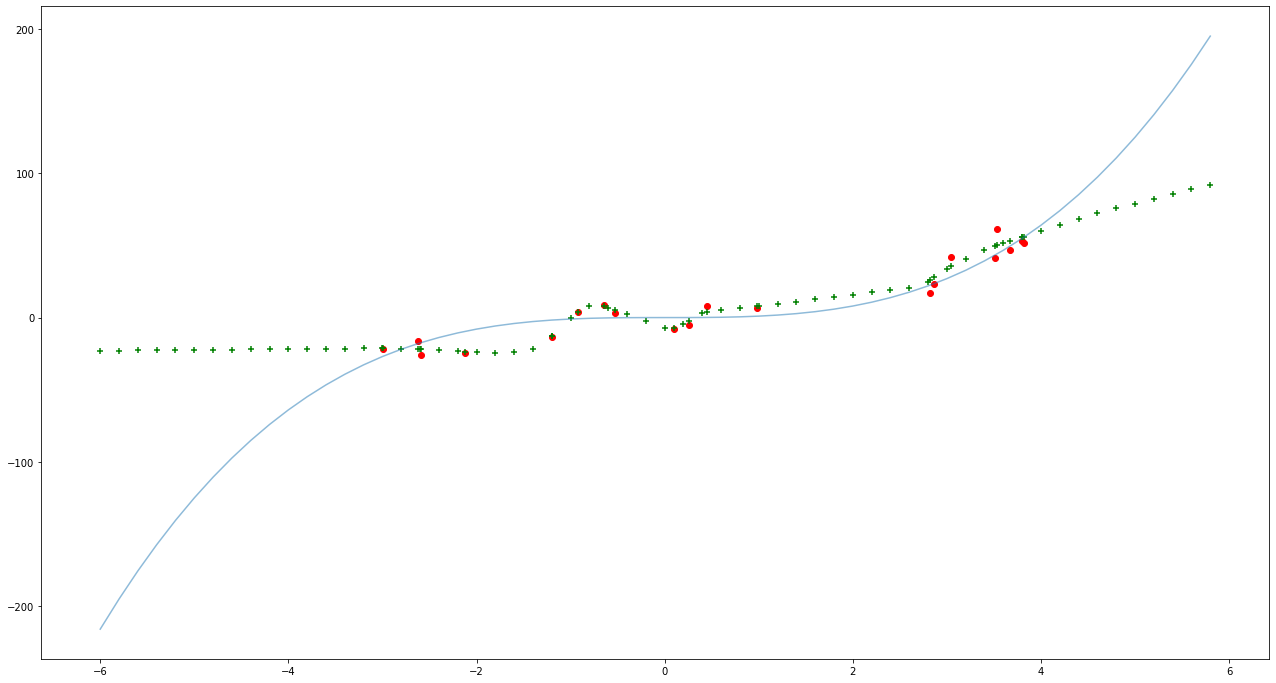

In [6]:
model = Dense(config['layers']).float()

trainer = Trainer(
    model, batch_size=15, dropout_train=config['dropout_train'],
    loss=torch.nn.functional.mse_loss, regression=True)
trainer.fit(
    (x_train, y_train), (x_val, y_val), patience=config['patience'],
     verbose=False, epochs=10000)

x_ = np.concatenate((x_true, x_train))
y_ = trainer.predict(x_)
plt.figure(figsize=(22, 12))
plt.plot(x_true, y_true, alpha=0.5)
plt.scatter(x_train, y_train, color='red')
plt.scatter(x_, y_, color='green', marker='+')
